## Testing Spatial K-Fold Cross Validation

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../Scripts')
from deafrica_classificationtools import spatial_clusters, SKCV, spatial_train_test_split
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, GroupKFold

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Analysis Parameters

In [2]:
training_data = "eastern_cropmask/results/training_data/gm_mads_two_seasons_training_data_20201204.txt"
coordinate_data = "eastern_cropmask/results/training_data/training_data_coordinates_20201204.txt"

cv_splits = 5

max_distance = 250000

test_size = 0.20

cluster_method='Hierarchical'

### Load data

In [3]:
# load the data
model_input = np.loadtxt(training_data)
coordinates = np.loadtxt(coordinate_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

#convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

## Generate spatial clusters to visualize

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


n clusters = 89


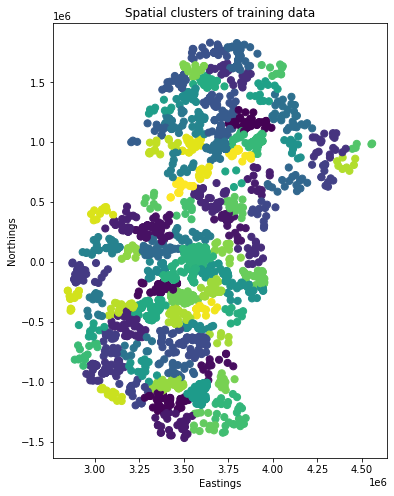

In [4]:
spatial_groups = spatial_clusters(coordinates, method='Hierarchical', max_distance=max_distance, verbose=True)

plt.figure(figsize=(6,8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=spatial_groups,
            s=50, cmap='viridis');
plt.title('Spatial clusters of training data')
plt.ylabel('Northings')
plt.xlabel('Eastings');

## Test the different SKCV methods and random shufflesplit

In [18]:
#generate n_splits of train-test_splits
kfold = SKCV(coordinates=coordinates,
    max_distance=max_distance,
    n_splits=cv_splits,
    cluster_method=cluster_method,
    kfold_method='SpatialKFold',
    test_size=test_size,
    balance=True
            )

kfold=kfold.split(coordinates)

shuffle = SKCV(coordinates=coordinates,
    max_distance=max_distance,
    n_splits=cv_splits,
    cluster_method=cluster_method,
    kfold_method='SpatialShuffleSplit',
    test_size=test_size,
    balance=10
              )
shuffle = shuffle.split(coordinates)

rs = ShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=0)
rs = rs.split(coordinates)

gss = GroupShuffleSplit(n_splits=cv_splits, test_size=test_size, random_state=0)
gss = gss.split(coordinates, groups=spatial_groups)

gkf = GroupKFold(n_splits=cv_splits)
gkf = gkf.split(coordinates, groups=spatial_groups)

### Plot train-test coordinate data

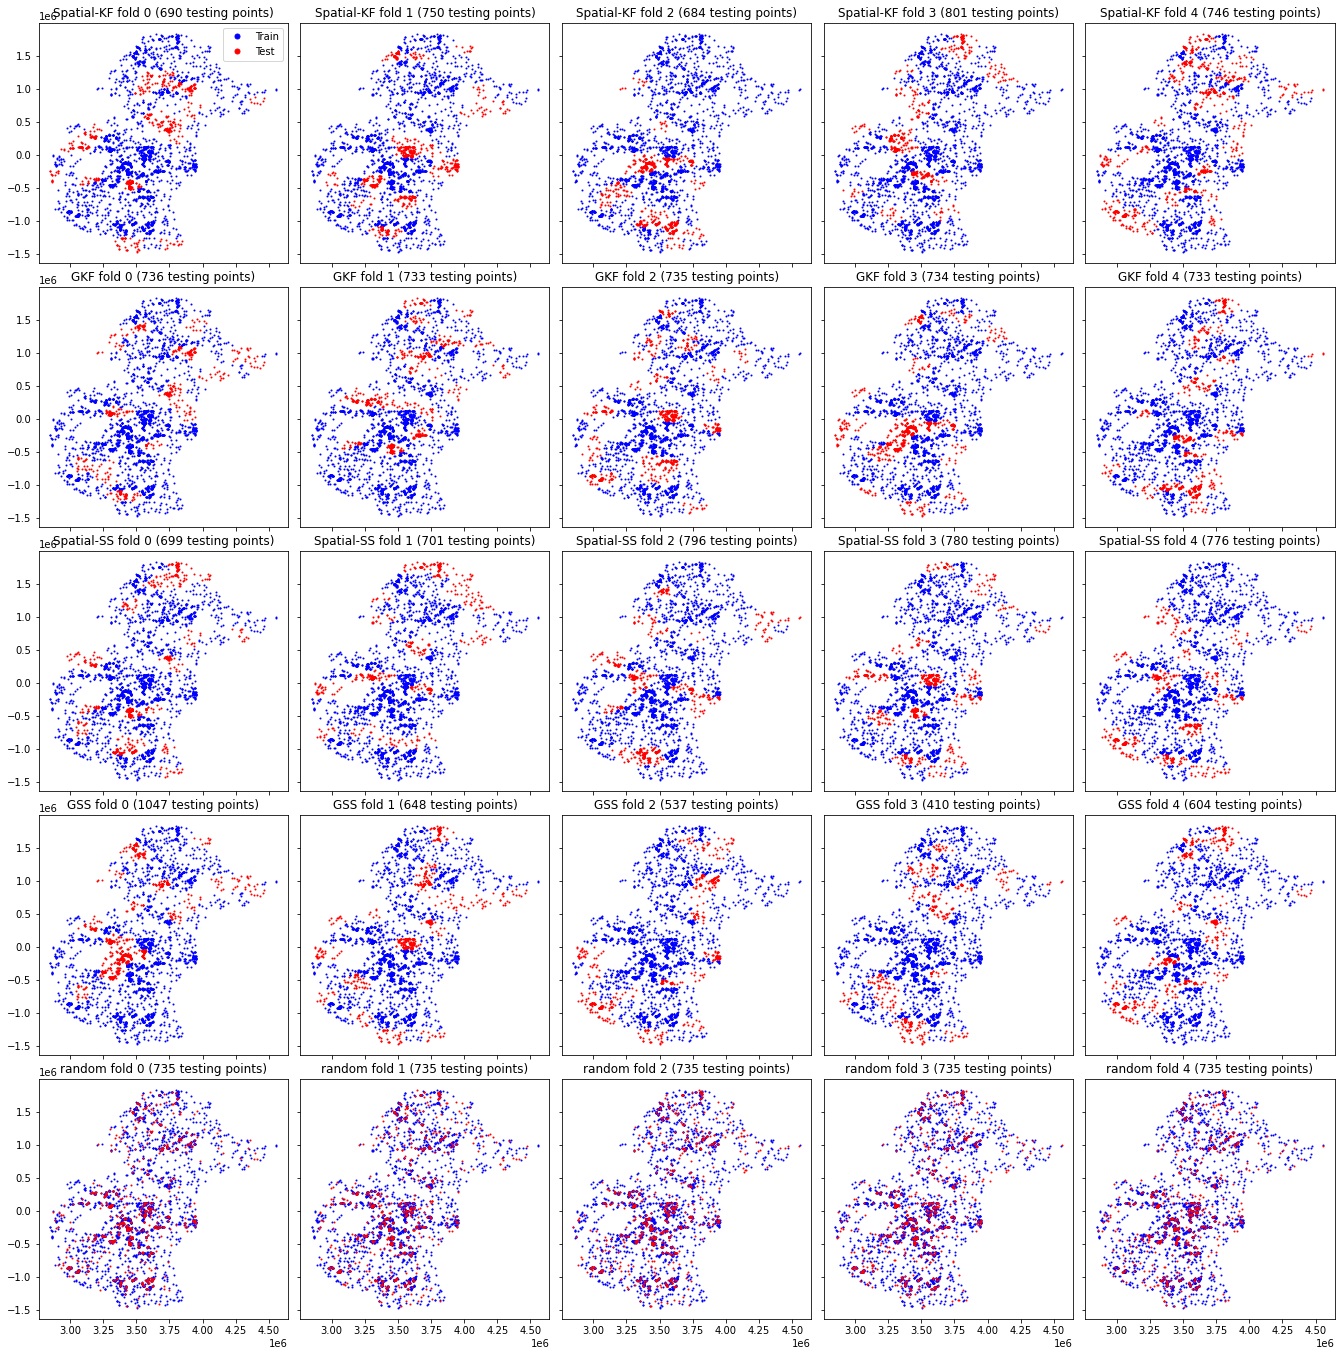

In [19]:
fig, axes = plt.subplots(
    5,
    cv_splits,
    figsize=(20, 20),
    sharex=True,
    sharey=True,
)

for row, title, folds in zip(axes, ['Spatial-KF', 'GKF','Spatial-SS','GSS', 'random'], [kfold,gkf,shuffle, gss, rs]):
    for i, (ax, fold) in enumerate(zip(row, folds)):
        train, test = fold
        X_tr, X_tt = coordinates[train,:], coordinates[test,:]
        
        ax.set_title("{} fold {} ({} testing points)".format(title, i, test.size))
        ax.plot(
            np.transpose(X_tr)[0],
            np.transpose(X_tr)[1],
            ".b",
            markersize=2,
            label="Train",
        )
        ax.plot(
            np.transpose(X_tt)[0],
            np.transpose(X_tt)[1],
            ".r",
            markersize=2,
            label="Test",
        )
# Place a legend on the first plot
axes[0, 0].legend(loc="upper right", markerscale=5)
plt.subplots_adjust(
    hspace=0.1, wspace=0.05, top=0.95, bottom=0.05, left=0.05, right=0.95
)
plt.show()

## Train-test-split

In [ ]:
train_features, test_features, train_labels, test_labels = spatial_train_test_split(X=model_input[:, model_col_indices],
                                                             y=model_input[:, 0],
                                                             coordinates = coordinates,
                                                             cluster_method='Hierarchical',
                                                             max_distance=max_distance,
                                                             kfold_method = 'SpatialShuffleSplit',                    
                                                             test_size=test_size,
                                                             random_state=0,
                                                             balance=10                          
                                                             )

print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)